<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br>
<b>Phase Curve of Solar System Objects</b> <br>
Contact authors: Christina Williams and Yumi Choi<br>
Last verified to run: <i>2023-07-dd</i> <br>
LSST Science Piplines version: Weekly <i>2023_21</i> <br>
Container Size: medium <br>
Targeted learning level: intermediate <br>

**Description:** Investigate the derivation of phase curves for DP0.3 solar system objects and explore DP0.3-provided phase curve parameters. 

**Skills:** Use various TAP tables, including joining multiple tables. Derive and compare phase curves. Explore accuracy of the phase curve parameters as a function of observation quality.

**LSST Data Products:** TAP tables dp03_catalogs_10yr.SSObject, dp03_catalogs_10yr.MPCORB, dp03_catalogs_10yr.DiaSource, dp03_catalogs_10yr.SSSource

**Packages:** numpy, scipy, pandas, matplotlib, seaborn, lsst.rsp

**Credit:**
Inspired by a jupyter notebook developed by Queen's University Belfast Planet Lab (including Brian Rogers, Niall McElroy, and Meg Schwamb). Standalone functions for phase curve fitting were developed by Pedro Bernardinelli. References: <a href="https://ui.adsabs.harvard.edu/abs/2010Icar..209..542M/abstract">Muinonen et al. (2010)</a> and <a href="http://astronotes.co.uk/blog/2018/05/28/determining-the-h-g-parameters-of-atlas-asteroid-phase-curves.html">David Young's webpage.</a> Please consider acknowledging them if this notebook is used for the preparation of journal articles, software releases, or other notebooks.Please consider acknowledging them if this notebook is used for the preparation of journal articles, software releases, or other notebooks.

**Get Support:** Find DP0.3-related documentation and resources at <a href="https://dp0-3.lsst.io">dp0-3.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

In [ ]:
%load_ext pycodestyle_magic
%flake8_on
import logging
logging.getLogger("flake8").setLevel(logging.FATAL)

## 1. Introduction

This notebook will explore the properties of solar system objects in the DP0.3 dataset by using the science example of measuring their phase curves. 

The DP0.3 catalog contains both real and simulated Solar System objects (including asteroids, near-earth objects, Trojans, trans-Neptunian objects) In the real survey, these objects will change position between each Rubin image. The DP0.3 catalog simulates the measurements of object movements between images, and these can be used to estimate their intrinsic properties and orbital parameters. An important way to characterize intrinsic properties of a solar system object is by measuring its "phase curve", which is the object brightness as a function of its "solar phase angle" (the angle made between the line of sight from the object to the sun, and the line of sight from the object to earth; see diagram at <a href="http://astronotes.co.uk/blog/2018/05/28/determining-the-h-g-parameters-of-atlas-asteroid-phase-curves.html">David Young's webpage.</a>)


In order to reveal the intrinsic properties of the asteroid (such as its surface properties and albedo; and as a result helps determine its class of solar system body) we first must turn apparent magnitudes as a function of time (what is measured by LSST data) into "reduced magnitude", which takes into account the relative distances between the asteroid and the sun/earth (heliocentric/topocentric distances) at each observation. Thus, reduced magnitude is normalized such that it is the brightness of an asteroid as if it is observed at 1 AU from both the Sun and the Earth. 

In this notebook we will show an example of measuring the phase curve of solar system bodies using the DP0.3 simulated catalogs. In Section 2 we will manually perform the phase curve fitting on the DP0.3 measurements for one solar system object, using 3 different parametrizations of the phase curve model (see Section 1.2). In Section 3, we will compare that to the automated phase curve fitting that is performed as part of the LSST data products, and available in the SSObject Table. Lastly in Section 4 we will aggregate the phase curve fits for a number of solar system bodies in DP0.3 and study how the quality of the fit depends on LSST observations (which additionally provides some insight into expectations for real LSST data).



### 1.1 Package Imports

The [matplotlib](https://matplotlib.org/) (and especially sublibrary `matplotlib.pyplot`), [numpy](http://www.numpy.org/), and [scipy](https://scipy.org/) libraries are widely used Python libraries for plotting and scientific computing, and model fitting.

The `lsst.rsp` package provides access to the Table Access Protocol (TAP) service for queries to the DP0 catalogs.

The [seaborn](https://seaborn.pydata.org/) package provides statistical data visualization with aesthetic and informative graphics.

The [pandas](https://pandas.pydata.org/) package enables table and dataset manipulation (TBD are we using this)


In [1]:
# general python packages
import numpy as np
from scipy.interpolate import CubicSpline
from scipy.optimize import leastsq
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# LSST package for TAP queries
from lsst.rsp import get_tap_service

### 1.2 Define Functions and Parameters

#### 1.2.1 Set up some plotting defaults:

In [2]:
plt.style.use('tableau-colorblind10')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
params = {'axes.labelsize': 15,
          'font.size': 15,
          'legend.fontsize': 12}
plt.rcParams.update(params)

To supress NumPy RuntimeWarning

In [3]:
np.seterr(divide='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

#### 1.2.2 Define functions for phase curve fitting. 
First we will define some arrays that will be used later by the phase curve fitting, followed by three different parametrizations of the phase curve or three different forms of phase curve function (confirm which one is more accurate wording). These are `HG_model`, `HG1G2_model`, `HG12_model`. The `HG_model` is the simpletest model, and has the form:

$$H(α)=H−2.5log_{10}[(1−G)Φ1(α)+GΦ2(α)],$$

where $Φ_n$ are basis functions normalized to unity at α=0 deg. This model provides a best fit for the slope parameter $G$ (from which surface properties can then be derived) and the absolute magnitude $H$. $H$(α) is a reduced magnitude at a given phase angle α if measured at 1 AU away from both earth and from the Sun (i.e. unit tropocentric and heliocentric distnace). The absolute magnitude $H$ is the value at 0 phase angle α. For further info on the `HG_model`, see [Bowell et al. 1989](https://ui.adsabs.harvard.edu/abs/1989aste.conf..524B/abstract). 


To better accommodate various observational effects (e.g., photometric quality, incomplete phase angle sampling) the more sophisticate `HG1G2_model` (a linear three-parameter phase function) and its nonlinear two-parameter version `HG12_model` were developed (see [Muinonen et al. 2010](https://ui.adsabs.harvard.edu/abs/2010Icar..209..542M/abstract)). The `HG1G2_model` has the form

$$H(α)=H−2.5log_{10}[G_1Φ_1(α)+G_2Φ_2(α) + (1-G_1-G_2)Φ3(α)],$$

which now has three free parameters, $H$, $G_1$ and $G_2$. However, a third representation, the `HG12_model`, is generally very effective for deriving reliable values of absolute magnitude when the phase angle sampling is not optimal (e.g., poor phase angle coverage at a range of phase anlge). Thus, the LSST data products will compute estimated parameters of the `HG12_model` and this will be the focus of this tutorial. The `HG12_model` expresses the $G_1$ and $G_2$ parameters as a piecewise lineary function of a single parameter, $G_{12}$, 

for $G_{12}$ > 0.2
$$G_1 = 0.9529\times G_{12} + 0.02162$$
$$G_2 = -0.6125\times G_{12} + 0.5572$$
for $G_{12}$ < 0.2
$$G_1 = 0.7527\times G_{12} + 0.06164$$
$$G_2 = -0.9612\times G_{12} + 0.6270$$


The constants used to define the basis functions are pre-defined below with values taken from `sbpy` (https://sbpy.org).

In [5]:
A = [3.332, 1.862]
B = [0.631, 1.218]
C = [0.986, 0.238]

alpha_12 = np.deg2rad([7.5, 30., 60, 90, 120, 150])

phi_1_sp = [7.5e-1, 3.3486016e-1, 1.3410560e-1, 5.1104756e-2, 2.1465687e-2,
            3.6396989e-3]
phi_1_derivs = [-1.9098593, -9.1328612e-2]

phi_2_sp = [9.25e-1, 6.2884169e-1, 3.1755495e-1, 1.2716367e-1, 2.2373903e-2,
            1.6505689e-4]
phi_2_derivs = [-5.7295780e-1, -8.6573138e-8]

alpha_3 = np.deg2rad([0.0, 0.3, 1., 2., 4., 8., 12., 20., 30.])

phi_3_sp = [1., 8.3381185e-1, 5.7735424e-1, 4.2144772e-1, 2.3174230e-1,
            1.0348178e-1, 6.1733473e-2, 1.6107006e-2, 0.]
phi_3_derivs = [-1.0630097, 0]

phi_1 = CubicSpline(alpha_12, phi_1_sp,
                    bc_type=((1, phi_1_derivs[0]), (1, phi_1_derivs[1])))
phi_2 = CubicSpline(alpha_12, phi_2_sp,
                    bc_type=((1, phi_2_derivs[0]), (1, phi_2_derivs[1])))
phi_3 = CubicSpline(alpha_3, phi_3_sp,
                    bc_type=((1, phi_3_derivs[0]), (1, phi_3_derivs[1])))

In [6]:
def HG_model(phase, params):
    """
    Compute HG model phase curve for a given set
    of parameters. The simplest 2-parameter model.

    Parameters
    ----------
    phase: ndarray
        phase angle in radians
    params: list
        phase curve parameters

    Returns
    -------
    computed reduced magnitude: ndarray
    """

    sin_a = np.sin(phase)
    tan_ah = np.tan(phase/2)

    W = np.exp(-90.56 * tan_ah * tan_ah)
    scale_sina = sin_a/(0.119 + 1.341*sin_a - 0.754*sin_a*sin_a)

    phi_1_S = 1 - C[0] * scale_sina
    phi_2_S = 1 - C[1] * scale_sina

    phi_1_L = np.exp(-A[0] * np.power(tan_ah, B[0]))
    phi_2_L = np.exp(-A[1] * np.power(tan_ah, B[1]))

    phi_1 = W * phi_1_S + (1-W) * phi_1_L
    phi_2 = W * phi_2_S + (1-W) * phi_2_L

    return params[0] - 2.5*np.log10((1-params[1]) * phi_1
                                    + (params[1]) * phi_2)

In [7]:
def HG1G2_model(phase, params):
    """
    Compute HG1G2 model phase curve for a given set
    of parameters. This is a 3-parameter model, which works best
    when sufficiently long phaseangle coverage is available.

    Parameters
    ----------
    phase: ndarray
        phase angle in radians
    params: list
        phase curve parameters

    Returns
    -------
    computed reduced magnitude: ndarray
    """

    phi_1_ev = phi_1(phase)
    phi_2_ev = phi_2(phase)
    phi_3_ev = phi_3(phase)

    msk = phase < 7.5 * np.pi/180

    phi_1_ev[msk] = 1-6 * phase[msk]/np.pi
    phi_2_ev[msk] = 1-9 * phase[msk]/(5 * np.pi)

    phi_3_ev[phase > np.pi/6] = 0

    return params[0] - 2.5 * np.log10(params[1] * phi_1_ev
                                      + params[2] * phi_2_ev
                                      + (1-params[1]-params[2]) * phi_3_ev)

In [8]:
def HG12_model(phase, params):
    """
    Compute HG12 model phase curve for a given set
    of parameters. This is a 2-parameter, simplified version
    of HG1G2 model, which is useful when phaseangle coverage is shorter.

    Parameters
    ----------
    phase: ndarray
        phase angle in radians
    params: list
        phase curve parameters

    Returns
    -------
    computed reduced magnitude: ndarray
    """

    if params[1] >= 0.2:
        G1 = +0.9529*params[1] + 0.02162
        G2 = -0.6125*params[1] + 0.5572
    else:
        G1 = +0.7527*params[1] + 0.06164
        G2 = -0.9612*params[1] + 0.6270

    return HG1G2_model(phase, [params[0], G1, G2])

In [10]:
def weighted_dev(params, mag, phase, mag_err, model):
    """
    Compute weighted deviation for a given model.
    """

    pred = model(phase, params)

    return (mag - pred)/mag_err

In [11]:
def fitPhaseCurve(mag, phase, sigma, model=HG12_model, params=[0.1]):
    """
    Fit phase curve for given observations to a designated model.

    Parameters
    ----------
    mag: ndarray
        reduced magnitude
    phase: ndarray
        phase angle in degrees
    sigma: ndarray
        uncertainty in magnitude
    model: function (default=HG12_model)
        phase curve model function
    params: list (default=[0.1])
        phase curve paramters

    Returns
    -------
    sol: tuple
        best-fit solution
    """

    phase = np.deg2rad(phase)
    sol = leastsq(weighted_dev, [mag[0]] + params, (mag, phase, sigma, model),
                  full_output=True)

    return sol

In [12]:
def fitAllPhaseCurveModels(reducedMag, magSigma, phaseAngle, verbose=False):
    """
    Fit phase curves for given observations to 3 different models.

    Parameters
    ----------
    reducedMag: ndarray
        reduced magnitude
    magSigma: ndarray
        uncertainty in magnitude
    phaseAngle: ndarray
        phase angle in degrees

    Returns
    -------
    solutions: dict
        Best-fit solutions for each model
    """

    # We fit observations using each one of the HG, HG12 and HG1G2 models
    # and store the resulting solutions in a dictionary of dictionaries.
    # Save np.nan values when the fit has not been converged
    solutions = {}

    # Let's do HG first
    sol_HG = fitPhaseCurve(reducedMag, phaseAngle, magSigma, model=HG_model)

    solutions['HG'] = {}
    try:
        solutions['HG']['chi2'] = np.sum(sol_HG[2]['fvec']**2)
        solutions['HG']['H'] = sol_HG[0][0]
        solutions['HG']['G'] = sol_HG[0][1]
        solutions['HG']['H_err'] = np.sqrt(sol_HG[1][0, 0])
        solutions['HG']['G_err'] = np.sqrt(sol_HG[1][1, 1])
        solutions['HG']['cov'] = sol_HG[1]
    except TypeError:
        if verbose:
            print('HG model is not converging')
        solutions['HG']['chi2'] = np.nan
        solutions['HG']['H'] = np.nan
        solutions['HG']['G'] = np.nan
        solutions['HG']['H_err'] = np.nan
        solutions['HG']['G_err'] = np.nan
        solutions['HG']['cov'] = np.nan

    # Now HG12
    sol_HG12 = fitPhaseCurve(reducedMag, phaseAngle,
                             magSigma, model=HG12_model)

    solutions['HG12'] = {}
    try:
        solutions['HG12']['chi2'] = np.sum(sol_HG12[2]['fvec']**2)
        solutions['HG12']['H'] = sol_HG12[0][0]
        solutions['HG12']['G12'] = sol_HG12[0][1]
        solutions['HG12']['H_err'] = np.sqrt(sol_HG12[1][0, 0])
        solutions['HG12']['G12_err'] = np.sqrt(sol_HG12[1][1, 1])
        solutions['HG12']['cov'] = sol_HG12[1]
    except TypeError:
        if verbose:
            print('HG12 model is not converging')
        solutions['HG12']['chi2'] = np.nan
        solutions['HG12']['H'] = np.nan
        solutions['HG12']['G12'] = np.nan
        solutions['HG12']['H_err'] = np.nan
        solutions['HG12']['G12_err'] = np.nan
        solutions['HG12']['cov'] = np.nan

    # Finally, HG1G2 - note this returns an extra parameter
    sol_HG1G2 = fitPhaseCurve(reducedMag, phaseAngle, magSigma,
                              model=HG1G2_model, params=[0.1, 0.1])

    solutions['HG1G2'] = {}
    try:
        solutions['HG1G2']['chi2'] = np.sum(sol_HG1G2[2]['fvec']**2)
        solutions['HG1G2']['H'] = sol_HG1G2[0][0]
        solutions['HG1G2']['G1'] = sol_HG1G2[0][1]
        solutions['HG1G2']['G2'] = sol_HG1G2[0][2]
        solutions['HG1G2']['H_err'] = np.sqrt(sol_HG1G2[1][0, 0])
        solutions['HG1G2']['G1_err'] = np.sqrt(sol_HG1G2[1][1, 1])
        solutions['HG1G2']['G2_err'] = np.sqrt(sol_HG1G2[1][2, 2])
        solutions['HG1G2']['cov'] = sol_HG1G2[1]
    except TypeError:
        if verbose:
            print('HG1G2 model is not converging')
        solutions['HG1G2']['chi2'] = np.nan
        solutions['HG1G2']['H'] = np.nan
        solutions['HG1G2']['G1'] = np.nan
        solutions['HG1G2']['G2'] = np.nan
        solutions['HG1G2']['H_err'] = np.nan
        solutions['HG1G2']['G1_err'] = np.nan
        solutions['HG1G2']['G2_err'] = np.nan
        solutions['HG1G2']['cov'] = np.nan

    return solutions

## 2. Querying the DP0.3 tables and fitting phase curves of SS objects

### 2.1 Create the Rubin TAP Service Client

Get an instance of the TAP service, and assert that it exists.

In [13]:
service = get_tap_service("ssotap")
assert service is not None

### 2.2 Querying the DP0.3 SSObject and MPCORB catalogs

For phase curve fitting, we need apparent magnitudes & uncertainties, phase angles, topocentric (tdist) and heliocentric (rdist) distances.

To define the properties of solar system objects, the DP0.3 model uses the `HG_model` form of the phase curve to predict the observed parameters for each object. These "truth" values are defined in the MPCORB table as mpcH (intrinsic absolute magnitude) and mpcG (intrinsic slope). For the purposes of DP0.3, the intrinsic slope, mpcG, for all objects have a constant value of 0.15.

In the ssObjectTable, the LSST data products contain the fitted phase curve parameters based on the mock observations using the `HG12_model` (i.e. contain absolute magnitude H and slope parameter G12). Note that the value of G12 slope will differ from G owing to the difference in functional form. 

To keep a reasonable run time for this tutorial, we limit our query, and select sources with a large number of observations (in the ssObject table, this is numObs > 2200) and, to ensure we select a relatively nearby sample that will have high-quality measurements, we choose perihelion distance of less than 20 AU (in the MPCORB talble, q < 20). Optionally, one can also restrict on the arc of LSST observations (arc) > 1000 days. 

We call the table returned by this query "unique" since it contains the IDs of unique solar system objects (although each object has many individual observations in LSST)

TBD: are limits on both arc and nobs necessary or would just one do?

In [14]:
nobs_thrh = '2200'  # Number of LSST observations
q_thrh = '20'  # Perihelion distance (AU)
# arc_thrh = '1000'  # Arc of LSST observations; units in days

In [15]:
query = """
SELECT
    mpc.ssObjectId, mpc.q, mpc.mpcG, mpc.mpcH,
    sso.arc, sso.numObs,
    sso.g_H, sso.g_Herr, sso.g_G12, sso.g_G12err, sso.g_H_gG12_Cov,
    sso.r_H, sso.r_Herr, sso.r_G12, sso.r_G12err, sso.r_H_rG12_Cov,
    sso.i_H, sso.i_Herr, sso.i_G12, sso.i_G12err, sso.i_H_iG12_Cov,
    sso.z_H, sso.z_Herr, sso.z_G12, sso.z_G12err, sso.z_H_zG12_Cov
FROM
    dp03_catalogs_10yr.MPCORB as mpc
INNER JOIN dp03_catalogs_10yr.SSObject as sso
ON mpc.ssObjectId = sso.ssObjectId
WHERE sso.numObs > {} AND mpc.q < {} ORDER by sso.ssObjectId
""".format(nobs_thrh, q_thrh)

df_uniqueObj = service.search(query).to_table()
df_uniqueObj

ssObjectId,q,mpcG,mpcH,arc,numObs,g_H,g_Herr,g_G12,g_G12err,g_H_gG12_Cov,r_H,r_Herr,r_G12,r_G12err,r_H_rG12_Cov,i_H,i_Herr,i_G12,i_G12err,i_H_iG12_Cov,z_H,z_Herr,z_G12,z_G12err,z_H_zG12_Cov
,AU,,mag,d,,mag,mag,mag,mag,mag2,mag,mag,mag,mag,mag2,mag,mag,mag,mag,mag2,mag,mag,mag,mag,mag2
int64,float64,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
-9217466392671047318,2.361473543230547,0.15,14.48,3099.2915,2866,15.203103,0.00038897144,0.4550666,0.0040478734,7.9422597e-07,14.554703,0.00021039916,0.48015854,0.0020262992,1.7115104e-07,14.354623,0.00025000537,0.4709413,0.0025779733,2.3757198e-07,14.407989,0.0006071515,0.51356506,0.005866336,1.1365114e-06
-9129158858340072847,4.718197768357827,0.15,14.74,2401.9941,2697,15.293133,0.008127137,0.61724746,0.04248245,0.0003319727,14.822511,0.005298313,0.6399376,0.027943237,0.00014214222,14.724821,0.007258602,0.75881785,0.039108675,0.00027342155,14.709886,0.01570672,0.7537519,0.0867984,0.001313763
-9023703058184288186,2.217745941240826,0.15,16.64,2817.7273,2331,17.358274,0.0035483497,0.50554883,0.036873408,7.245376e-05,16.716164,0.001927695,0.5128336,0.018558158,2.0433228e-05,16.515278,0.0023644213,0.4923302,0.024016123,3.2025448e-05,16.568754,0.005117289,0.5263797,0.04942868,0.00014278179
-8941112935633645120,1.900063249965985,0.15,17.46,3111.7393,2357,18.188131,0.0013846699,0.5111664,0.011265048,8.2808214e-07,17.539248,0.0007647462,0.48283827,0.005792018,3.7366075e-07,17.337635,0.0010335406,0.5097,0.007862881,-1.0053393e-06,17.386505,0.0027831802,0.5375992,0.025589064,-2.3151732e-05
-8848841739843330269,2.7552357886722616,0.15,16.99,3627.043,2617,17.53464,0.0016498883,0.4948764,0.01436597,8.768694e-06,17.061077,0.0011163031,0.48569593,0.0095817065,4.305333e-06,16.940798,0.0014123438,0.48687568,0.012630372,6.103225e-06,16.943336,0.003720296,0.5370097,0.036412716,5.3106625e-05
-8546690224401666693,2.1785005989989807,0.15,14.21,3221.1025,2585,14.933542,0.0003713474,0.49537596,0.0037509156,6.1889216e-07,14.28519,0.00021029617,0.51621103,0.0016754025,1.9517809e-07,14.085621,0.0002519965,0.51197493,0.0021872101,2.4994083e-07,14.139268,0.0005213929,0.53697747,0.004472232,7.74557e-07
-8444163840568729078,4.373425784935888,0.15,14.48,3580.974,2224,15.045554,0.0102379415,0.71682644,0.061094522,0.0006080503,14.5655775,0.0065039233,0.6757668,0.038757242,0.00024473254,14.453941,0.008034859,0.69401264,0.050451104,0.00039183773,14.453052,0.019853927,0.71889913,0.11451077,0.0022028165
-8387582028637110093,2.775865705521247,0.15,16.06,3612.9668,2538,16.785315,0.0024384111,0.5531357,0.014856289,2.963824e-05,16.131733,0.0014233812,0.5255428,0.008418158,9.753402e-06,15.932856,0.001762171,0.51812345,0.010576296,1.5140969e-05,15.984991,0.0037547762,0.52475655,0.023032127,6.713406e-05


### 2.3 Querying the DP0.3 DiaSource and SSSource catalogs

While there are unique solar system objects in the ssObject and MPCORB tables, these objects will be observed many times over the full LSST survey. Individual observations of each unique object are recorded in the SSSource and diaSource tables. Below, we query these tables to obtain all of the individual observed time series data (we call indivObsv) for the unique objects (uniqueObj) selected above. This query usually takes ~30 sec.

In [16]:
query = """
SELECT
    dia.ssObjectId, dia.diaSourceId, dia.mag,
    dia.magErr, dia.band, dia.midPointMjdTai,
    sss.phaseAngle, sss.topocentricDist, sss.heliocentricDist
FROM
    dp03_catalogs_10yr.DiaSource as dia
INNER JOIN
    dp03_catalogs_10yr.SSSource as sss
ON
    dia.diaSourceId = sss.diaSourceId
WHERE
    dia.ssObjectId
    IN {}
ORDER by dia.ssObjectId
""".format(tuple(df_uniqueObj['ssObjectId']))

df_indivObsv = service.search(query).to_table()
df_indivObsv

ssObjectId,diaSourceId,mag,magErr,band,midPointMjdTai,phaseAngle,topocentricDist,heliocentricDist
,,,,,d,deg,AU,AU
int64,int64,float32,float32,str1,float64,float32,float32,float32
-9217466392671047318,5074726492115737,20.055,0.012,r,61021.35247,17.301477,2.711414,3.1537251
-9217466392671047318,19481485662802488,19.669,0.007,i,61033.2511,15.801364,2.5499394,3.1503248
-9217466392671047318,39913165364548592,20.21,0.009,r,61010.34128,18.036163,2.8695178,3.1563327
-9217466392671047318,48327202766987632,19.45,0.01,z,61049.34712,12.501292,2.3604758,3.14477
-9217466392671047318,48371439483286632,19.711,0.008,i,61031.33981,16.094881,2.5749133,3.1509116
-9217466392671047318,62341640397910521,20.195,0.008,g,61051.17905,12.03446,2.3417952,3.144068
-9217466392671047318,73744426738833766,20.075,0.016,i,61005.35388,18.184,2.9424236,3.1573431
-9217466392671047318,75023334125204409,20.044,0.014,r,61021.3483,17.301888,2.711473,3.1537263


As a sanity check, here we confirm that the number of unique objects in `df_indivObsv` is identical to that of `df_uniqueObj`, as they should be.

In [17]:
assert len(df_uniqueObj) == len(np.unique(df_indivObsv['ssObjectId']))

### 2.4 Fitting phase curve per filter per unique object using three different fitting functions

To plot the phase curve, we firs tmust compute the reduced magnitude H($\alpha$) for each observation, and add it as a column to the `df_indivObsv` table we produced of individual observations. The educed magnitude H(a) as mentioned in Section 1.2 is the normalized apparent magnitude of an asteroid to make as if it is observed at 1 AU from both the Sun and the Earth as a function of phase angle a, once accounting for the relative distances between the asteroid, and both sun and earth (thdist).

In [24]:
thdist = df_indivObsv['topocentricDist']*df_indivObsv['heliocentricDist']
dmag = -5. * np.log10(thdist)
reduced_mag = df_indivObsv['mag'] + dmag

df_indivObsv.add_column(reduced_mag, name='reducedMag')

ValueError: Cannot replace column 'reducedMag'.  Use Table.replace_column() instead.

In the cell below, we now fit the phase curve for one unique object in each LSST filter using the three different fitting functions, `HG_model`, `HG1G2_model` and `HG12_model`. This cell takes ~6 min for 269 unique objects with the medium container size (TBD UPDATE). The output x_fitted contains the parameters that are returned for each model fit (optionally uncomment to inspect).



In [19]:
fitted_array = []

for iobj in df_uniqueObj['ssObjectId']:
    idx = df_indivObsv['ssObjectId'] == iobj
    df_tmp = df_indivObsv[idx]
    filts_tmp = np.unique(df_tmp['band'])
    for ifilt in filts_tmp:
        idx_filt = df_tmp['band'] == ifilt
        nobs_ifilt = len(df_tmp[idx_filt])

        # number of observations must be greater
        # than the number of fit parameters (3)
        if nobs_ifilt > 3:
            x_fitted = fitAllPhaseCurveModels(df_tmp['reducedMag'][idx_filt],
                                              df_tmp['magErr'][idx_filt],
                                              df_tmp['phaseAngle'][idx_filt])
            fitted_array.append([iobj, ifilt, x_fitted])

results = pd.DataFrame(fitted_array)
results.columns = ['ssObjectId', 'fname', 'fit_param']
# print(x_fitted)

Finally, we convert the fit parameter dictionary to individual columns in a pandas dataframe, to make it easy to read each parameter. 

In [20]:
L = ['ssObjectId', 'fname']
results = results[L].join(pd.json_normalize(results.fit_param))

Now, we will plot example phase curves in all available filters (in DP0.3) g,r,i,z for a single object referenced by its ssObjectId, which we call `sId`. (You can explore different objects by changing the iObj index to retrieve different sources). Below you will see that the reduced magnitude and phase curve of the source are offset from eachother in each filter, reflecting the variation in brightness of asteroids in different filters. Overall you see that the 3 different fitted models all describe the observations well for well-sampled phase curves in DP0.3.

Text(0.5, 1.0, 'ssObjectId = -8136314917321805229')

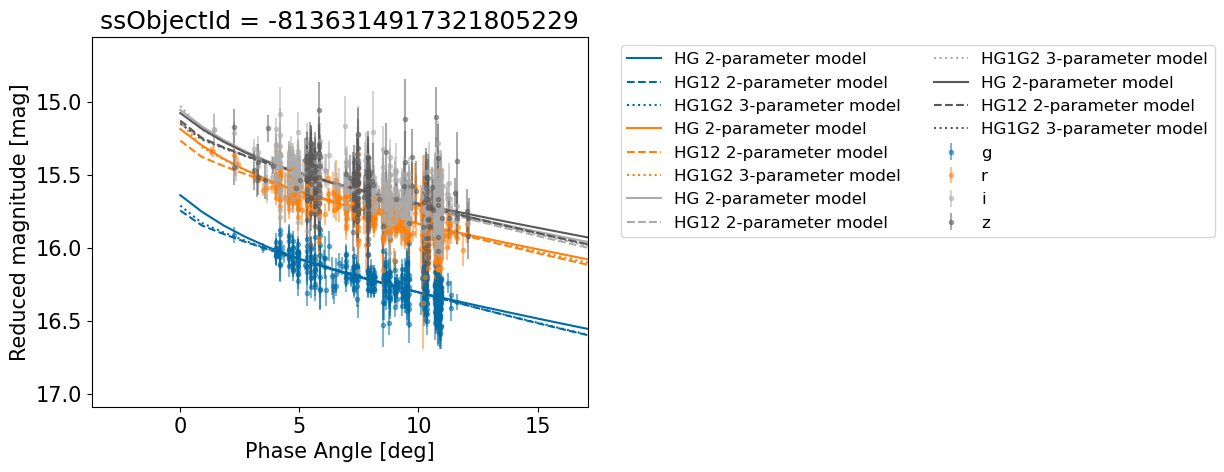

In [21]:
filts = ['g', 'r', 'i', 'z']
iObj = 11  # you can pick any integer number between 0 and len(df_uniqueObj)-1
sId = df_uniqueObj['ssObjectId'][iObj]
df_tmp = df_indivObsv[df_indivObsv['ssObjectId'] == sId]
phases = np.linspace(0, 90, 100)

for i, ifilt in enumerate(filts):
    idx = df_tmp['band'] == ifilt

    # Plot observations
    plt.errorbar(df_tmp['phaseAngle'][idx], df_tmp['reducedMag'][idx],
                 yerr=df_tmp['magErr'][idx], fmt='.', color=colors[i],
                 alpha=0.5, label=ifilt)

    # Plot HG model
    HG_mag = HG_model(np.deg2rad(phases),
                      [results[(results.ssObjectId == sId) & (results.fname == ifilt)]['HG.H'].values,
                       results[(results.ssObjectId == sId) & (results.fname == ifilt)]['HG.G'].values])
    plt.plot(phases, HG_mag, color=colors[i],
             label='HG 2-parameter model')

    # Plot HG12 model
    HG12_mag = HG12_model(np.deg2rad(phases),
                          [results[(results.ssObjectId == sId) & (results.fname == ifilt)]['HG12.H'].values,
                           results[(results.ssObjectId == sId) & (results.fname == ifilt)]['HG12.G12'].values])
    plt.plot(phases, HG12_mag, color=colors[i], linestyle='--',
             label='HG12 2-parameter model')

    # Plot HG1G2 model
    HG1G2_mag = HG1G2_model(np.deg2rad(phases),
                            [results[(results.ssObjectId == sId) & (results.fname == ifilt)]['HG1G2.H'].values,
                             results[(results.ssObjectId == sId) & (results.fname == ifilt)]['HG1G2.G1'].values,
                             results[(results.ssObjectId == sId) & (results.fname == ifilt)]['HG1G2.G2'].values])
    plt.plot(phases, HG1G2_mag, color=colors[i], linestyle='dotted',
             label='HG1G2 3-parameter model')

plt.xlim(df_tmp['phaseAngle'].min()-5, df_tmp['phaseAngle'].max()+5)
plt.ylim(df_tmp['reducedMag'].max()+0.5, df_tmp['reducedMag'].min()-0.5)
plt.xlabel('Phase Angle [deg]')
plt.ylabel('Reduced magnitude [mag]')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', ncol=2)
plt.title('ssObjectId = %d' % sId)

# 3. Comparing to the automated phase curve data in the ssObject Table

While modeling phase curves manually using these three fitting functions demonstrates the process, the `HG12_model` results (the parametrization that is more stable to limited observations across phase angles) will automatically be tabulated as a data product during the course of the survey in the ssObject table. Thus in this section we will compare the manually derived parameters from the last section with those produced in LSST data products.


### 3.1 Explore phase curve fit uncertainty

For the same unique object we studied in Section 2.4, we focus on the $g$- and $z$-filters to demonstrate fit uncertainty between two filters that produce different reduced magnitude quality for the asteroids (mostly due to difference in brightness and therefore flux uncertainties between the filters). First, we retrieve the phase curve parameters for the `HG12_model` stored in SSObject Table, which we will call `HG12_mag_sso`. In priciple, these parameters should be identical to those derived for the `HG12_model` above in this notebook since they were modeled using the same functional form, and this plot shows that is the case.

Further, the second plot shows the uncertainty in the model parameters represented by the shaded regions. Choosing fainter or less well-sampled SSObjects increases the error region.


Text(0.5, 1.0, 'ssObjectId = -8136314917321805229')

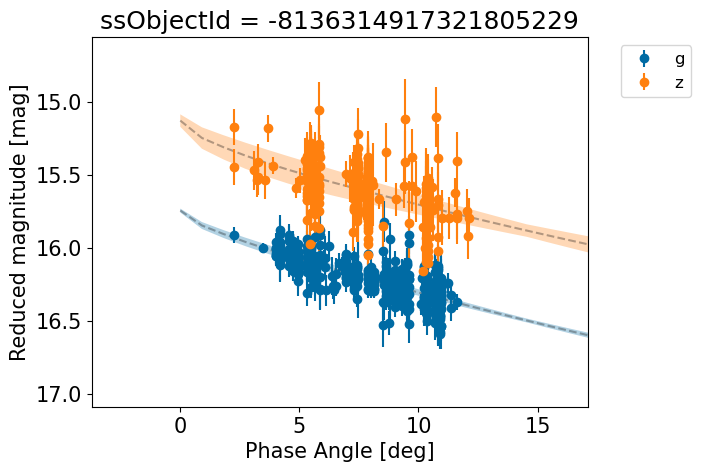

In [22]:
for ifilt in ['g', 'z']:
    idx = df_tmp['band'] == ifilt
    plt.errorbar(df_tmp['phaseAngle'][idx], df_tmp['reducedMag'][idx],
                 yerr=df_tmp['magErr'][idx], fmt='o', label=ifilt, zorder=10)

    HG12_mag_sso = HG12_model(np.deg2rad(phases), [df_uniqueObj[ifilt+'_H'][iObj],
                                                   df_uniqueObj[ifilt+'_G12'][iObj]])
    plt.plot(phases, HG12_mag_sso, 'k--', alpha=0.3)

    # Compute min/max values in reduced mag at each phase angle
    p1 = HG12_model(np.deg2rad(phases),
                    [df_uniqueObj[ifilt+'_H'][iObj] + df_uniqueObj[ifilt+'_Herr'][iObj],
                     df_uniqueObj[ifilt+'_G12'][iObj] + df_uniqueObj[ifilt+'_G12err'][iObj]])

    p2 = HG12_model(np.deg2rad(phases),
                    [df_uniqueObj[ifilt+'_H'][iObj] - df_uniqueObj[ifilt+'_Herr'][iObj],
                     df_uniqueObj[ifilt+'_G12'][iObj] + df_uniqueObj[ifilt+'_G12err'][iObj]])

    p3 = HG12_model(np.deg2rad(phases),
                    [df_uniqueObj[ifilt+'_H'][iObj] + df_uniqueObj[ifilt+'_Herr'][iObj],
                     df_uniqueObj[ifilt+'_G12'][iObj] - df_uniqueObj[ifilt+'_G12err'][iObj]])

    p4 = HG12_model(np.deg2rad(phases),
                    [df_uniqueObj[ifilt+'_H'][iObj] - df_uniqueObj[ifilt+'_Herr'][iObj],
                     df_uniqueObj[ifilt+'_G12'][iObj] - df_uniqueObj[ifilt+'_G12err'][iObj]])

    HG_magHigh = np.maximum(np.maximum(p1, p2), np.maximum(p3, p4))
    HG_magLow = np.minimum(np.minimum(p1, p2), np.minimum(p3, p4))

    plt.fill_between(phases, HG_magLow, HG_magHigh, alpha=0.3)

plt.xlim(df_tmp['phaseAngle'].min()-5, df_tmp['phaseAngle'].max()+5)
plt.ylim(df_tmp['reducedMag'].max()+0.5, df_tmp['reducedMag'].min()-0.5)
plt.xlabel('Phase Angle [deg]')
plt.ylabel('Reduced magnitude [mag]')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title('ssObjectId = %d' % sId)

In the below figure, we take the manually-derived G12 parameter from the phase curves for each of our unique selected solar system objects to that generated automatically in the ssObject table in DP0.3. Here you can see that overall the manual measurement recovers the DP0.3 value and uncertainty, demonstrating that `HG12` model was used to produce the DP0.3 fits.

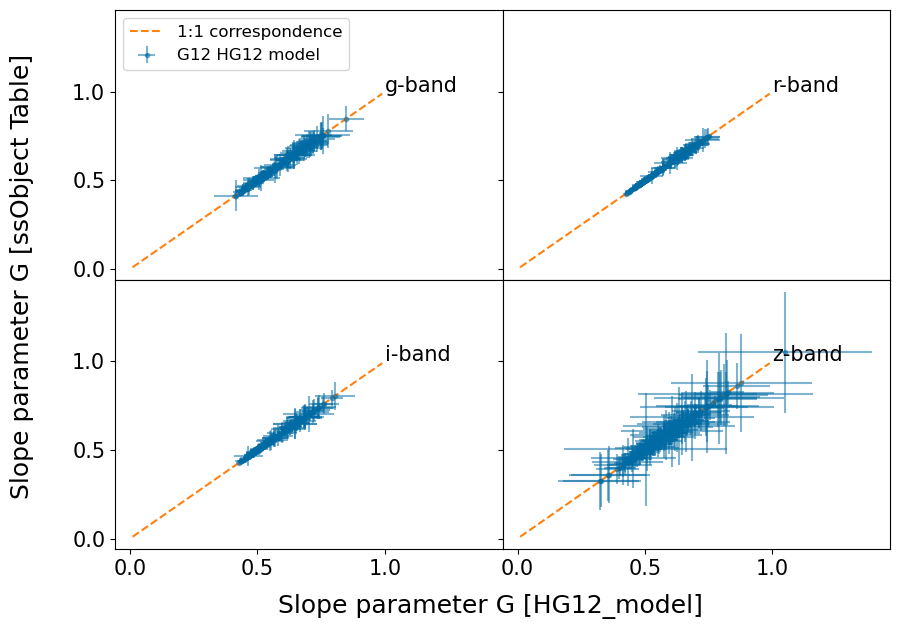

In [23]:
fig = plt.figure(figsize=(10, 7))
gs = fig.add_gridspec(2, 2, wspace=0, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)
axs = axs.ravel()

one2one = np.arange(0.01, 1, .01)
filts = ['g', 'r', 'i', 'z']
for i, ifilt in enumerate(filts):

    axs[i].errorbar(results[results.fname == ifilt]['HG12.G12'],
                    df_uniqueObj[ifilt+'_G12'],
                    xerr=results[results.fname == ifilt]['HG12.G12_err'],
                    yerr=df_uniqueObj[ifilt+'_G12err'], fmt='.', alpha=0.5,
                    label='G12 HG12 model')

    axs[i].plot(one2one, one2one, '--', label='1:1 correspondence')
    axs[i].text(1, 1, ifilt+'-band')

fig.supxlabel('Slope parameter G [HG12_model]')
fig.supylabel('Slope parameter G [ssObject Table]')
axs[0].legend(loc=2)

## 4. Population study of measurements of the SS objects DP0.3 tables 

Now that we have demonstrated how to fit a phase curve to DP0.3 data, experimented with 3 different models, and compared those to the automated fits that are stored in the SSObject Table, we look at the population in aggregate to see how e.g., how the fit values differ due to number of observations, or for near/far or bright/faint objects.



Here we compare the typical apparent magnitude uncertainties per band to see how that impacts the fit. To do this, we compute the median apparent magnitude (i.e. as observed) and its median uncertainty in the r-filter in this example. This allows us to plot phase curve parameters vs. median apparent magnitude and its median uncertainty to see how these observational characteristics impact the resulting modeling. One can see in the plot that as objects get fainter and the median apparent magnitude uncertainty increases, so does the uncertainty in the fitted parameters of the phase curve. 

TBD: why do there appear to be two discrete uncertainty distributions (curves) for each parameter, rather than 1 smooth distribution?

In [ ]:
mag_med = []
magSigma_med = []
ifilt = 'r'

for iobj in df_uniqueObj['ssObjectId']:
    idx = df_indivObsv['ssObjectId'] == iobj
    df_tmp = df_indivObsv[idx]
    idx_filt = df_tmp['band'] == ifilt

    mag_med.append(np.median(df_tmp['mag'][idx_filt]))
    magSigma_med.append(np.median(df_tmp['magErr'][idx_filt]))

plt.figure(figsize=(13, 5))

plt.subplot(121)
plt.plot(mag_med, df_uniqueObj[ifilt+'_Herr'], '.', alpha=.5,
         label=ifilt+'-band abs mag H')
plt.plot(mag_med, df_uniqueObj[ifilt+'_G12err'], '.', alpha=.5,
         label=ifilt+'-band G parameter')
plt.ylabel('Uncertainty in phase curve fit')
plt.xlabel('Median apparent mag')
plt.legend()

plt.subplot(122)
plt.plot(magSigma_med, df_uniqueObj[ifilt+'_Herr'], '.', alpha=.5)
plt.plot(magSigma_med, df_uniqueObj[ifilt+'_G12err'], '.', alpha=.5)
plt.ylabel('Uncertainty in phase curve fit')
plt.xlabel('Median uncertainty in apparent mag')

plt.tight_layout()

In [ ]:
# del df_uniqueObj, df_indivObsv, results

Remember, however, in our first query in Section 2, we specifically selected solar system objects with excellent observations. So to fully explore the quality of the parameters for sources in DP0.3, we should first re-query for a table of columns for unique objects with number of observations and arc over larger dynamic range than before, and add some extra criteria of use in assessing uncertainty. 

To obtain a random distribution to work with without an overwhelming number of objects, we select 50,000 objects that meet our larger dynamic range criteria.

In [ ]:
nobs_thrh = 50
arc_thrh = 100

query = """
SELECT TOP 50000
    mpc.ssObjectId, mpc.q, sso.arc, sso.numObs,
    sso.g_H, sso.g_Herr, sso.g_G12, sso.g_G12err,
    sso.r_H, sso.r_Herr, sso.r_G12, sso.r_G12err,
    sso.i_H, sso.i_Herr, sso.i_G12, sso.i_G12err,
    sso.z_H, sso.z_Herr, sso.z_G12, sso.z_G12err,
    sso.g_Ndata, sso.r_Ndata,
    sso.i_Ndata, sso.z_Ndata
FROM
    dp03_catalogs_10yr.MPCORB as mpc
INNER JOIN dp03_catalogs_10yr.SSObject as sso
ON mpc.ssObjectId = sso.ssObjectId
WHERE sso.numObs > {} AND sso.arc > {}
""".format(nobs_thrh, arc_thrh)

res = service.search(query).to_table().to_pandas()
res

### 4.1 Distribution of H and G12 parameters in observed filters

First, lets explore the distribution of typical values of the G12 slope parameter as a function of absolute magnitudes across this larger dynamic range of objects. Remember that  the input (truth) G value using the `HG_model` that was used to generate the DP0.3 simulated object's observed properties was fixed across the population to a cosntant value of G=0.15. The DP0.3 automated phase curve modeling (which uses `HG12_model`) overall produces a nearly constant value for G12 with a relatively small spread at bright magnitudes (i.e. the measured output of G12 is relatively constant across the population) and the scatter in measured G12 starts to deviate more substantially at fainter magnitudes where its likely harder to recover the intrinsic value.

TBD: why do we expect the G12 to be constant if G was constant, can we add this explanation?

In [ ]:
fig = plt.figure(figsize=(13, 8))
gs = fig.add_gridspec(2, 2, wspace=0, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)
axs = axs.ravel()

for i, ifilt in enumerate(filts):
    sns.histplot(x=res[ifilt+'_H'], y=res[ifilt+'_G12'], bins=100,
                 log_scale=(False, True), ax=axs[i])
    axs[i].text(20, 30, ifilt+'-band')
    axs[i].set(xlabel=None)
    axs[i].set(ylabel=None)

plt.xlim(10, 30)
plt.ylim(1e-3, 1e3)

fig.supxlabel('Absolute magnitude, H [mag]')
fig.supylabel('Slope parameter, G12')

### 4.2 How model quality depends on total number and time baseline of LSST observations

Second, we have a look at how phase curve modeling accuracy might depend on "global" measurements (across all filters). For this section we compare total number of observations for a given source (numObs) and the total time baseline across which observations are made (arc of LSST observations) and explore whether or not these factors impact the quality of phase curve modeling. In general, the first plot shows that more observations yields lower uncertainties in the model fits. I have to admit I don't totally understand the middle plots comparing uncertainties as a function of time baseline of observations (arc). I am guessing that longer arc does not translate directly to lower uncertainties, since most(?) of the objects in the catalog are distant (fewer sources close to sun?).

Since distant objects can have quite long orbits, perhaps the requisite arc for a good fit varies substantially within the population? Maybe this plot would yield better results if the comparison is made after the sample is grouped by heliocentric distance or something.

It is clear that the model uncertainties decrease overall with number of observations of each source. So as the LSST progresses, our measurements will improve as we accumulate data.

In [ ]:
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(2, 3, wspace=0)
axs = gs.subplots(sharey=True)

sns.histplot(x=res['numObs'], y=res['i_Herr'], bins=100,
             log_scale=(True, True), ax=axs[0, 0])
axs[0, 0].set_xlabel('Number of LSST observations')
plt.ylim(1e-4, 1e3)

sns.histplot(x=res['arc'], y=res['i_Herr'], bins=100, ax=axs[0, 1])
axs[0, 1].set_xlabel('Arc [days]')

sns.histplot(x=res['q'], y=res['i_Herr'], bins=100, ax=axs[0, 2])
axs[0, 2].set_xlabel('perihelion distance [AU]')

sns.histplot(x=res['numObs'], y=res['i_G12err'], log_scale=(True, True),
             bins=100, ax=axs[1, 0])
axs[1, 0].set_xlabel('Number of LSST observations')

sns.histplot(x=res['arc'], y=res['i_G12err'], bins=100, ax=axs[1, 1])
axs[1, 1].set_xlabel('Arc [days]')

sns.histplot(x=res['q'], y=res['i_G12err'], bins=100, ax=axs[1, 2])
axs[1, 2].set_xlabel('perihelion distance [AU]')

### 4.3 Number of data used per band

The above plots compare numObs (total) with model fits (per band) which may not be the ideal metric since as one can see from the modeling of individual objects in different filters in Section 2.4, the quality of phase curves can vary quite a bit between filters. Instead, we can look at the number of datapoints included in the phase curve modeling on a per filter basis (i.e. rNdata for the r-band in the SSObject Table). Below, we look at the distribution of the number of observations in each filter used to model the phase curve per filter for all SSObjects which in total have more than 100 numObs and arc (as per query above). One can see that generally, r and i bands produce the most data points for recovering phase curves, while g-band produces the fewest. Phase curves measured in r and i will thus be better sampled. 

Thus in the second panel, one can see that poorer sampling drives higher uncertainty in H using g-band instead of r-band for solar system objects. 

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(13, 4))

filters = ['g', 'r', 'i', 'z']
for i, ifilt in enumerate(filters):
    axs[0].hist(res[ifilt+'_Ndata'], bins=100, range=(0, 1300),
                histtype='step', label=ifilt+'-band')

axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].legend()
axs[0].set_xlabel('Number of data points per filter')
axs[0].set_ylabel('Number of sources')

#sns.histplot(x=res['r_Ndata'], y=res['r_Herr'],
#             bins=100, log_scale=(True, True), color='r', ax=axs[1])
#sns.histplot(x=res['g_Ndata'], y=res['g_Herr'],
#             bins=100, log_scale=(True, True), color='b', ax=axs[1], alpha=0.7)
sns.histplot(x=res['r_Herr'], y=res['g_Herr'],
             bins=100, log_scale=(True, True), color='b', ax=axs[1], alpha=0.7)

#sns.histplot(x=res['r_Ndata'], y=100*res['r_Herr']/res['r_H'],
#             bins=100, log_scale=(True, True), color='r', ax=axs[1])
#sns.histplot(x=res['g_Ndata'], y=100*res['g_Herr']/res['g_H'],
#             bins=100, log_scale=(True, True), color='b', ax=axs[1], alpha=0.7)
one2one = np.arange(1e-4,1000,.1)
axs[1].plot(one2one,one2one,'--')
axs[1].set_ylim(1e-4, 1e2)
axs[1].set_xlim(1e-4, 1e2)
#axs[1].set_xlabel('Number of data points per filter')
#axs[1].set_ylabel('Fractional Uncertainty in H [%]')
axs[1].set_ylabel('Uncertainty in H using g-band')
axs[1].set_xlabel('Uncertainty in H using r-band')
#r_patch = mpatches.Patch(color='red', label='r-band')
#u_patch = mpatches.Patch(color='blue', label='g-band', alpha=0.7)
#axs[1].legend(handles=[r_patch, u_patch])